In [1]:
# Modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as sns

# Feature Selection
import xgboost as xgb
from sklearn.decomposition import PCA

# Evaluate Algorithms

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
from acquire_prepare import acquire_oil
from acquire_prepare import prep_data

import model
from model import polynomial_regression_model
from model import run_models

import numpy as np
import pandas as pd

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import sys 

**Let's bring in the DataFrame**

In [3]:
df = acquire_oil()
df = prep_data(df)

**(Rows, Columns)**

In [4]:
df.shape

(7888, 62)

### XGBoost Feature Recommender

In [10]:
xgb_df = scaled_df.copy()

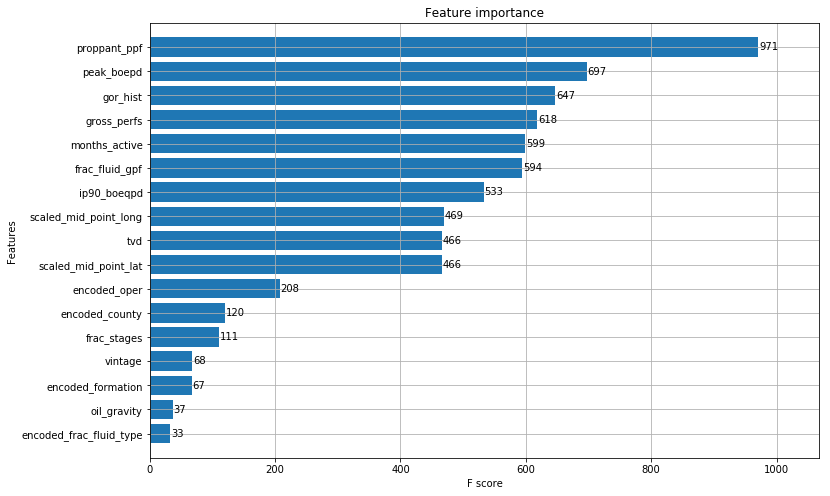

In [11]:
xgb_params = {
    'max_depth': 8,
    'seed' : 493
}

dtrain = xgb.DMatrix(xgb_df, df.oil_hist, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

# Test Harness and Options

In [24]:
xfeatures = ['proppant_ppf', 'frac_fluid_gpf', 'gor_hist', 'tvd', 'mid_point_lat', 'mid_point_long', 'encoded_oper', 'encoded_direction', 'vintage', 'gross_perfs']
yfeature = ['recovery']

In [25]:
#xfeatures = ['proppant_ppf', 'gross_perfs', 'tvd', 'frac_fluid_gpf', 'gor_hist', 'encoded_oper', 'vintage']
#yfeature = ['recovery']

### Results for the entire dataframe to use as a baseline before clustering

Linear Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 118.29709192213996
R2 score of training set is 0.27950245371651505


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.2820627  0.26077653 0.28240076]


The model performance for the test set
-------------------------------------------
RMSE of test set is 123.31566598092769
R2 score of test set is 0.2679755150397769




Ridge Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 118.26731952920882
R2 score of training set is 0.27986507018283224


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.28241993 0.26151098 0.28247902]


The model performance for the test set
-------------------------------------------
RMSE of test set is 1

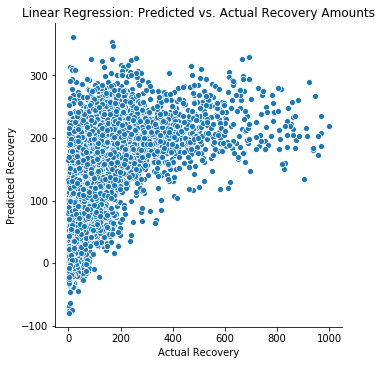

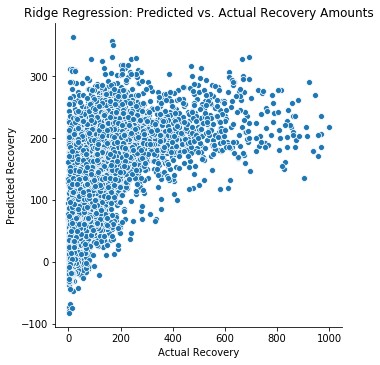

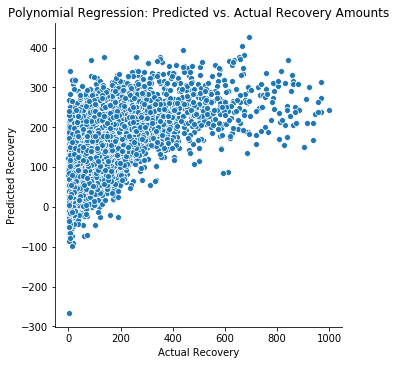

In [26]:
model.run_models(df, xfeatures, yfeature, 0.80)

**Let's Cluster by our Top Seven features per our XGBoost function**

In [27]:
# col_list = ['scaled_proppant_ppf', 'scaled_gross_perfs', 'scaled_tvd', 'scaled_frac_fluid_gpf', 
#             'scaled_gor_hist', 'encoded_oper', 'scaled_vintage']

In [28]:
col_list = ['proppant_ppf', 'gross_perfs', 'tvd', 'frac_fluid_gpf', 
            'gor_hist', 'encoded_oper', 'vintage']

**We now have a new dataframe with an added column "cluster_id"**

In [29]:
df = model.create_kclusters(df, col_list, 3, 'cluster_id')

**Let's see how many oberservations we have in each cluster**

In [30]:
df.cluster_id.value_counts()

1    5277
0    1422
2    1189
Name: cluster_id, dtype: int64

In [31]:
df.to_excel('CapstoneDataFinal.xlsx')

# ALL Regression Types on Each Cluster

### Cluster 0: 4,862 Oberservations 

In [32]:
cluster_zero = df[df['cluster_id'] == 0]

Linear Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 39.594209874080626
R2 score of training set is 0.25247840156685686


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.12240251 0.26951893 0.22948685]


The model performance for the test set
-------------------------------------------
RMSE of test set is 58.378286310539224
R2 score of test set is 0.13780127708194834




Ridge Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 38.36225457337305
R2 score of training set is 0.29827228441131315


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.19328944 0.27396474 0.23806021]


The model performance for the test set
-------------------------------------------
RMSE of test set is 5

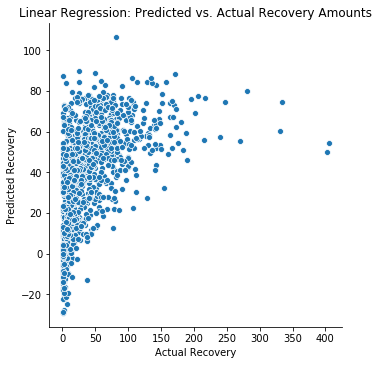

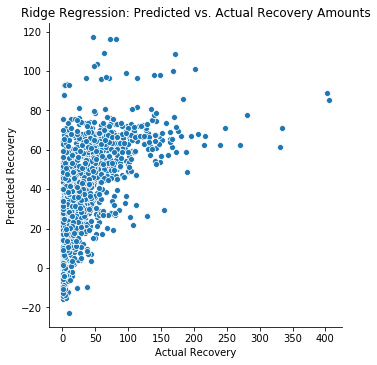

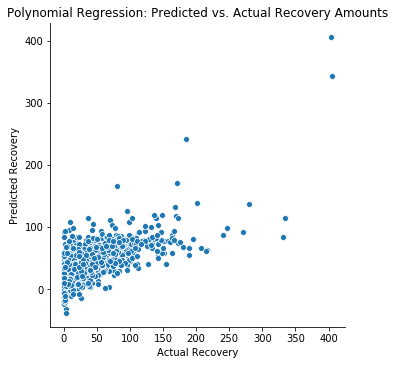

In [33]:
model.run_models(cluster_zero, xfeatures, yfeature, 0.70)

### Cluster 1: 1,714 Observations

In [34]:
cluster_one = df[df['cluster_id'] == 1]

Linear Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 136.39965975806732
R2 score of training set is 0.14811458788358134


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.11859984 0.14757836 0.16351908]


The model performance for the test set
-------------------------------------------
RMSE of test set is 126.7916171041451
R2 score of test set is 0.16547715215692882




Ridge Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 136.3798347779008
R2 score of training set is 0.14836220410334933


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.11917869 0.14795402 0.16180963]


The model performance for the test set
-------------------------------------------
RMSE of test set is 12

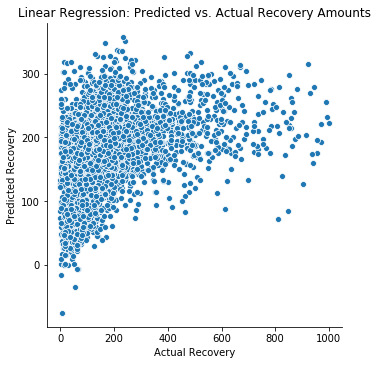

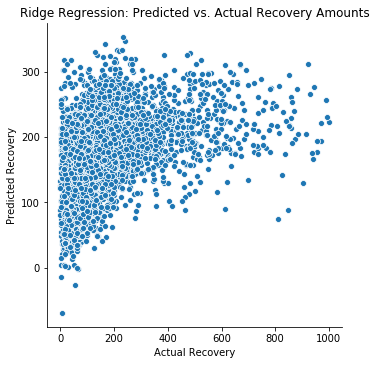

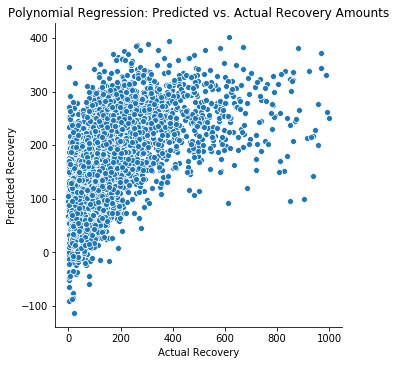

In [35]:
model.run_models(cluster_one, xfeatures, yfeature, 0.70)

### Cluster 2: 1,232 Observations

In [36]:
cluster_two = df[df['cluster_id'] == 2]

Linear Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 100.50286372632854
R2 score of training set is 0.30135660500239614


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.30718551 0.22585761 0.27464178]


The model performance for the test set
-------------------------------------------
RMSE of test set is 103.90717998455965
R2 score of test set is 0.3186747479930331




Ridge Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 98.33748708153689
R2 score of training set is 0.3311374251016329


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.33668422 0.26302657 0.29921645]


The model performance for the test set
-------------------------------------------
RMSE of test set is 104

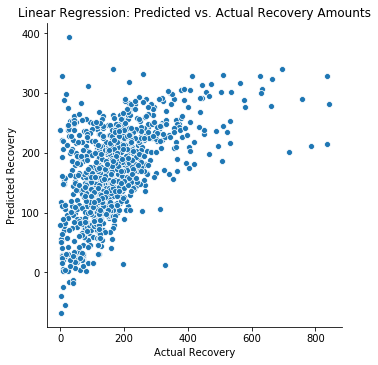

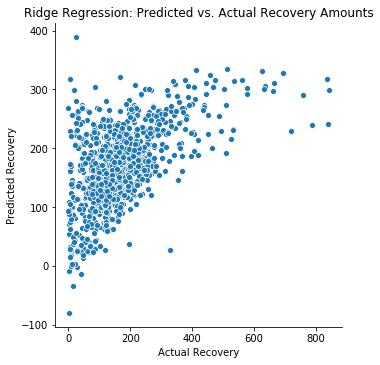

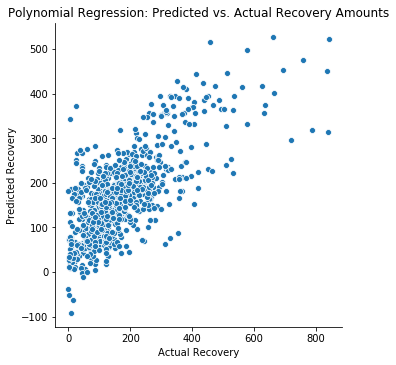

In [37]:
model.run_models(cluster_two, xfeatures, yfeature, 0.70)

## Interpret and report results

# Improve Results

## Algorithm Tuning

## Ensemble Methods

### Bagging

### Boosting

### Blending

## Extreme Feature Engineering